In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

 ##Topic Modelling: 
Topic modeling is an unsupervised learning technique used to extract topics from a large corpus of text automatically. Topics can be defined as the co-occurring terms that are frequently repeating in the text corpus. Topic modeling is helpful in various tasks such as clustering documents, understanding and summarizing an extensive collection of textual documents and retrieving information from an extensive collection of data, etc. In this notebook I will perform topic modelling using LDA(Latent Dirichlet Allocation) and BERT. 

Here I am using medium article dataset to perfom Topic Modelling. The dataset consist 350 articles related to AI, Machine Learning and Data Science.

## Exploring the dataset :

In [ ]:
medium_articles = pd.read_csv("../input/medium-articles/articles.csv")
medium_articles.head()

In [ ]:
article_text = medium_articles.text
# visualise first article print few words from it
#print("First 1000 words in first article are : \n",article_text[0][:1000])

#total number of author
print(f"Total Number of unique authors : {len(medium_articles.author.unique())}")

#counting the articles of different authors
article_counts = dict()
for author in medium_articles.author:
    article_count = len(medium_articles[medium_articles["author"]==author])
    article_counts[author] = article_count

#sorting the article_counts on the basis of article count
article_counts = dict(sorted(article_counts.items(), key=lambda x: x[1], reverse=True))


#plot histogram of top 10 authors and their article counts
plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
sns.barplot(x = list(article_counts.keys())[:10],y=list(article_counts.values())[:10])
plt.title("Authors and Number of Articles")
plt.xlabel("Authors")
plt.ylabel("No. of Articles")
plt.xticks(rotation = 90) 



#counting the total number of claps for each author
def convert_to_num(clap_count):
    if "K" in clap_count:
        if "." in clap_count:
            clap_count = re.sub("\.","",clap_count[:-1])+"00"
        else:
            clap_count = clap_count[:-1]+"000"
    return(int(clap_count))

medium_articles.claps = medium_articles.claps.apply(convert_to_num)

#couting total number of claps for each author
clap_counts = dict()
for author in medium_articles.author:
    clap_count = medium_articles[medium_articles["author"]==author]["claps"]
    clap_counts[author] = sum(clap_count)

#sort clap_counts on the basis of counting of claps
clap_counts = dict(sorted(clap_counts.items(), key=lambda x: x[1], reverse=True))

#plot histogram of top 10 authors and their article counts
plt.subplot(1, 2, 2)
sns.barplot(x = list(clap_counts.keys())[:10],y=list(clap_counts.values())[:10])
plt.title("Authors and Number of Claps")
plt.xlabel("Authors")
plt.ylabel("No. of Claps")
plt.xticks(rotation = 90) 
plt.show()

**The above graphs show that Adam Getigey has written most articles and has the highest number of claps. But when it comes to the 2nd, 3rd positions, the author's name is not the same in the graphs. It shows that either the reach of articles or the quality of articles is inadequate for the authors.**

Here, we can see that Adam Geitgey has written highest number of articles.

## Preprocessing Text Data

In [ ]:
#lowercase the articles 
medium_articles.text = medium_articles.text.apply(lambda t : t.lower())

**Expanding contractions:** Contractions are the shortened form of the words like it's, hasn't. We expand them for better analysis of our text data. I have taken these contractions from [Analytics Vidhay's article](http://https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/).

In [ ]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the text data
medium_articles.text = medium_articles.text.apply(lambda x:expand_contractions(x))

**Removing Stopwords and Puctuations**: Stopwords are the words that are highly occurred in a language; they do not add any significance to the sentence. "a," "an," "the," "in" are some examples of stopwords. So we generally ignore stop words during our NLP task. In some NLP tasks, stop words are also important, but stopwords are unnecessary for topic modeling. We also remove punctuation marks because they are also unnecessary and do not contribute anything.

In [ ]:
print(stopwords.words('english'))

In [ ]:
print(f"These are the pucntions which string.punctuation consist :  {string.punctuation}")

In [ ]:
stop_words = set(stopwords.words('english')) 

def remove_stopwords(article):
    "Return the articel after remvoing stopwords"
    article_tokens = word_tokenize(article) 
    filtered_article = [word for word in article_tokens if not word in stop_words] 
    return " ".join(filtered_article)


#removing stopwords
medium_articles.text = medium_articles.text.apply(remove_stopwords)

#removing Punctuations 
medium_articles.text = medium_articles.text.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

#removing digits
medium_articles.text = medium_articles.text.apply(lambda x: re.sub('\w*\d\w*','', x))

medium_articles.text[50]

There are still some marks like quotation marks, hypen and apostrophe still remaining in the article, we also need to remove them.

In [ ]:
def remove_extra_marks(article):
    extra_keys = ["’","—","”","“"]
    article_tokens = word_tokenize(article) 
    filtered_article = [word for word in article_tokens if not word in extra_keys] 
    return " ".join(filtered_article)
    
medium_articles.text = medium_articles.text.apply(remove_extra_marks)

In [ ]:
#printing arbitrary example to visulise clean data
medium_articles.text[50]

**Lemmaztisation:** Lemmatization process Topic modeling algorithm to avoid making mistakes by converting the word in its root from like lemmatization prevents counting "help", "helps", "helping" as three different words. Stemming can also be used, but it performs the task more forcefully, and sometimes the word loses its meaning, so I prefer lemmatization for the topic modeling task.

Here I am using **spacy** library to perform the lemmatizaton task.

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
print(f""" "helps" after lemmztization :  {nlp("helps")[0].lemma_}""")
print(f""" "helping" after lemmztization :  {nlp("helping")[0].lemma_}""")

In [ ]:
def lemmatize(text):
    """Return text after performing the lemmztiztion"""
    doc = nlp(text)
    tokens = [token for token in doc]
    return  " ".join([token.lemma_ for token in doc])

#lemmatize the articles
medium_articles.text = medium_articles.text.apply(lemmatize)

Now we have finished with all the data preprocessing steps, and let's plot a word cloud to visualize the most frequently used words and see the most commonly occurred word in the articles.

In [ ]:
import wordcloud
from wordcloud import WordCloud

#combine all the articles
article_data = ""
for article in medium_articles.text:
    article_data = article_data+" "+article

#ploting the word cloud
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width = 500, height = 500, background_color='#40E0D0', colormap="ocean",  random_state=10).generate(article_data)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Latent Dirichlet Allocation[LDA]:  

LDA algorithm is an unsupervised learning algorithm that works on a probabilistic statistical model to discover topics that the document contains automatically. <br> 
This algorithm works on certain assumptions. The assumption is that the document was generated by picking a set of topics and picking a set of words for each topic. In other words, we can say that the document is a probability distribution over the latent topics, and topics are probability distribution over the words.

Now let's understand the work methodology of LDA using Plate Diagram:
<br>

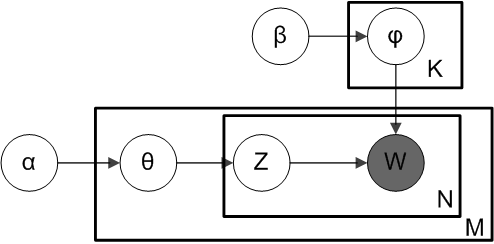
             
               **Plate Diagram of LDA model**

The above image is taken from [Wikipedia](http://https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Smoothed_LDA.png/377px-Smoothed_LDA.png)

Here, $\alpha$ and $\beta$ are two hyperparameters that we have to initialise manually, and they symbolize per topic distribution($\alpha$) and per topic word distribution($\beta$), respectively. And **Z** is the topic for the **N**-th word in document **M**, and **W** is the specific word. We can only see W(specific words) in the documents because it is only an observable variable, and all others are latent.

$\theta$ is the matrix where rows are the documents; columns are topics, and $\theta(i,j)$ represents the probability of $ith$ document containing $jth$ topic. Similarly, $\phi$ is the matrix where rows are the topics; columns are words, and $\phi(i,j)$ represents the probability of $ith$ topic containing $jth$ word. According to the distribution of $\phi$; **K** individual words are generated for the topics.

With the help of this LDA, try to estimate the words that belong to each topic and find the topics in documents accordingly.

In [ ]:
#tokenize articles
tokeize_article = medium_articles.text.apply(lambda x : x.split())
id2word = corpora.Dictionary(tokeize_article)

# Create Corpus
texts = tokeize_article

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


#printing 50 words from the text corpus
corpus_example = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]
corpus_example[0][:50]

In [ ]:
# build LDA model for 10 topic
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           per_word_topics=True,
                                           eta = 0.6)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

We can interpret this output as for topic 0, word, vector,ai, make, cluster, go, system, use, one are 10 most important keywords. The weight of "ai" on topic 0 is 0.008.

### Visualising Topics:

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

To measure how good is our model we can use **perplexity score** and **coherence socre**. The lower score of perplexity is better for the model.

In [ ]:
# Compute Perplexity
print('\nPerplexity : ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

This notebook is mainly focused on LDA implementation for coherence score you can read this [medium article](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0).

### Tuning hyperparameters:

We can try out different number of topics, different values of alpha and beta(eta) to increse the conharence score. High conherence score is good for our model.

In [ ]:
def calculate_coherence_score(n, alpha, beta):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

#list containing various hyperparameters
no_of_topics = [2,5,7,10,12,14]
alpha_list = ['symmetric',0.3,0.5,0.7]
beta_list = ['auto',0.3,0.5,0.7]


for n in no_of_topics:
    for alpha in alpha_list:
        for beta in beta_list:
            coherence_score = calculate_coherence_score(n, alpha, beta)
            print(f"n : {n} ; alpha : {alpha} ; beta : {beta} ; Score : {coherence_score}")

The highest coherence score is : 0.4962 for number of topics = 14  alpha = 0.3 and beta = auto

Final LDA Model :

In [ ]:
n = 14
alpha = 0.3
beta = "auto"
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis